In [2]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [3]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import os
import math
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
# Plotting 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('bmh') #Bayesian Methods for Hackers style
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [33]:
#Load data
yf.pdr_override()

start_date = '26-03-2022'
end_date = '26-03-2023'

company = 'NKE'

start = datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.strptime(end_date, '%d-%m-%Y')
df = pdr.get_data_yahoo(company, start=start, end=end)

df.style.format({"Date": lambda t: t.strftime("%d-%m-%Y")})

print(f'Name of company: {company} (Nike - USA)')

df.round(2)

[*********************100%***********************]  1 of 1 completed
Name of company: NKE (Nike - USA)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-28,133.76,134.86,132.17,134.81,133.30,5804100
2022-03-29,137.85,139.75,136.95,139.14,137.58,7275900
2022-03-30,138.98,139.86,137.56,138.54,136.99,5545800
2022-03-31,137.83,138.71,134.50,134.56,133.05,7206500
2022-04-01,134.45,135.28,132.75,133.52,132.03,5807500
...,...,...,...,...,...,...
2023-03-20,120.99,122.68,119.81,121.20,121.20,7594100
2023-03-21,123.50,126.06,122.97,125.61,125.61,15078800
2023-03-22,123.66,125.26,119.33,119.50,119.50,17625500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2022-03-28 to 2023-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 21.8 KB


## **DATA VISUALIZATION**

<Figure size 2000x400 with 0 Axes>

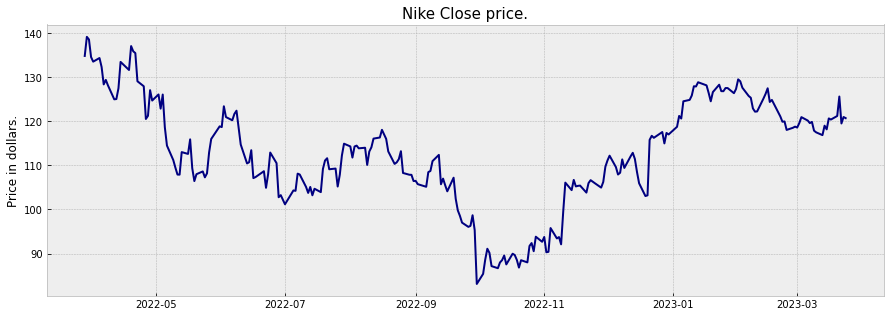

In [17]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.figure(figsize=(15,5))
plt.plot(df['Close'], color = 'navy')
plt.title('Nike Close price.', fontsize=15)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.ylabel('Price in dollars.')
plt.show()

Text(0.5, 1.0, 'Price history of NKE')

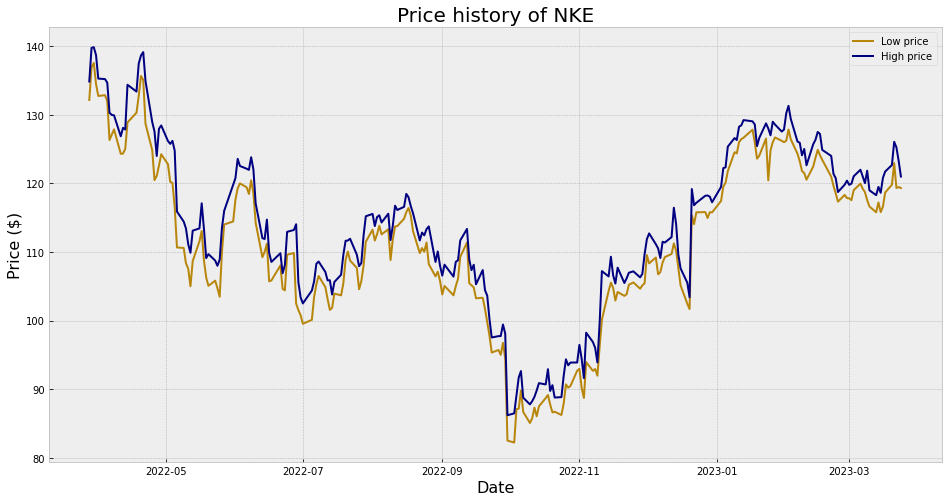

In [16]:
N = df.shape[0]
plt.figure(figsize = (16,8))
plt.plot(df['Low'], color = 'darkgoldenrod', label = 'Low price')
plt.plot(df['High'], color = 'navy', label = 'High price')
# plt.plot(df['Close'], color = 'yellow', label = 'Close price')
# plt.xticks(np.arange(0, N+1, np.int(N/5)), df['Date'][0:N:np.int(N/5)])
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Price ($)', fontsize = 16)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.legend()
plt.title('Price history of ' + company, fontsize = 20)

### **Candlestick Plots 🕯**

Ask any person in the financial domain, the best way to represent a stock in terms of a plot would be a **Candlestick** plot. These are essentially little boxplots that represent the Open, High, Close and Low of a stock on a given time frame. A red candlestick is a **bearish** candle (Closing price < Opening price) and a green candle is a **bullish** candle (Closing price > Opening price)

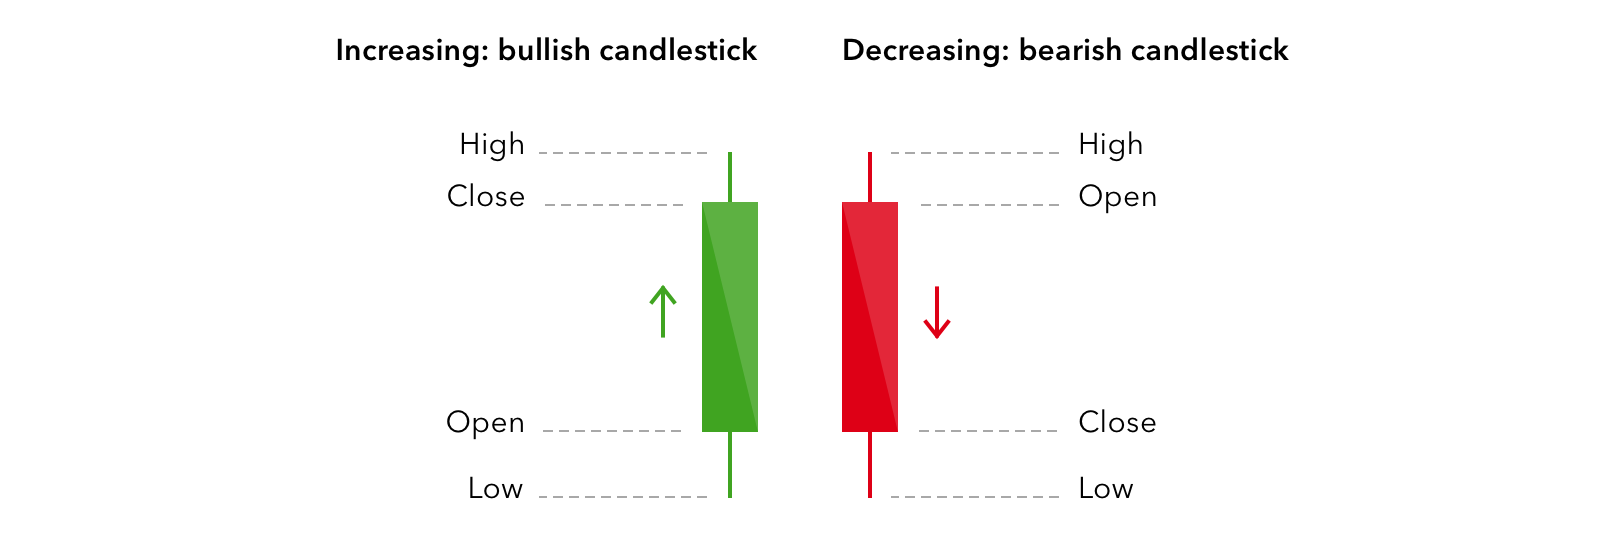

Reference of Image: [Increasing and Decreasing of Candlestick Chart](https://www.kaggle.com/code/yash161101/financial-charts-using-plotly-cheat-sheet)

In [ ]:
import plotly.graph_objects as go
from datetime import datetime

high_data = df['High']
open_data = df['Open']
low_data = df['Low']
close_data = df['Close']
dates = [datetime(year=2022, month=3, day=10),
         datetime(year=2022, month=4, day=10),
         datetime(year=2022, month=5, day=10),
         datetime(year=2022, month=6, day=10),
         datetime(year=2022, month=7, day=10),
         datetime(year=2022, month=8, day=10),
         datetime(year=2022, month=9, day=10),
         datetime(year=2022, month=10, day=10),
         datetime(year=2022, month=11, day=10),
         datetime(year=2022, month=12, day=10),
         datetime(year=2023, month=1, day=10),
         datetime(year=2023, month=2, day=10),
         datetime(year=2023, month=3, day=10)]

fig = go.Figure(data=[go.Candlestick(x=dates,
                       open=open_data, high=high_data,
                       low=low_data, close=close_data, increasing_line_color= 'green', decreasing_line_color= 'red')])

In [ ]:
fig.update_layout(
    title='Stock Price Status of NIKE company',
    yaxis_title='Price in dollars.')

fig.show()

Reference: [Candlestick Chart](https://plotly.com/python/candlestick-charts/)

## **FEATURE ENGINEERING**

In [38]:
def get_technical_indicators(original_dataset):
  dataset = original_dataset.copy()
  # Create 3, 7 and 21 days Moving Average
  dataset['ma3'] = np.log(dataset['Close'].rolling(window=3).mean()/dataset['Close'].rolling(window=3).mean().shift(1))

  dataset['ma5'] = np.log(dataset['Close'].rolling(window=5).mean()/dataset['Close'].rolling(window=5).mean().shift(1))

  dataset['ma21'] = np.log(dataset['Close'].rolling(window=21).mean()/dataset['Close'].rolling(window=21).mean().shift(1))

  
  # Create MACD
  dataset['26ema'] = np.log(dataset['Close'].ewm(span=26).mean()/dataset['Close'].ewm(span=26).mean().shift(1))
  dataset['12ema'] = np.log(dataset['Close'].ewm(span=12).mean()/dataset['Close'].ewm(span=12).mean().shift(1))
  dataset['MACD'] = dataset['12ema']-dataset['26ema']

  # # Create Bollinger Bands
  # dataset['20sd'] = np.log(dataset['Close'].rolling(window = 21).mean()/dataset['Close'].rolling(window = 21).mean().shift(1)).std()
  # dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
  # dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
  
  '''
  # Create Exponential moving average
  dataset['ema'] = np.log(dataset['Close'].ewm(com=0.5).mean()/dataset['Close'].ewm(com = 0.5).mean().shift(1))
  '''

  # Create Momentum
  dataset['momentum'] = np.log(dataset['Close']/dataset['Close'].shift(1))

  # Create 1 day volume and 3 days Moving Average volumne
  dataset['1_day_volume'] = np.log(dataset['Volume']/dataset['Volume'].shift(1))

  # Create 1 day return 
  dataset['1_day_return']  = np.log(dataset['Close']/dataset['Close'].shift(1))
  dataset.dropna(inplace=True)
  dataset.drop(columns=['High', 'Low', 'Open', 'Volume','Adj Close'], inplace=True)
  temp_cols=dataset.columns.tolist()
  # Move the target column to the last position to match the standard format
  new_cols=temp_cols[1:] + temp_cols[0:1]
  dataset=dataset[new_cols]
  return dataset

In [39]:
clean_data = get_technical_indicators(df)

In [40]:
clean_data

,ma3,ma5,ma21,26ema,12ema,MACD,momentum,1_day_volume,1_day_return,Close
Date,,,,,,,,,,
2022-04-27,-0.020958,-0.022805,-0.004926,-0.006509,-0.010320,-0.003811,0.005956,-0.283617,0.005956,121.239998
2022-04-28,-0.002410,-0.013349,-0.004409,-0.001843,-0.001585,0.000258,0.046809,0.086651,0.046809,127.050003
2022-04-29,0.011270,-0.007007,-0.005071,-0.003257,-0.004215,-0.000959,-0.018670,-0.110212,-0.018670,124.699997
2022-05-02,0.012893,-0.002997,-0.003120,-0.002009,-0.001864,0.000145,0.011006,-0.077852,0.011006,126.080002
2022-05-03,-0.011152,0.003770,-0.003936,-0.003963,-0.005526,-0.001564,-0.025871,0.412636,-0.025871,122.860001
...,...,...,...,...,...,...,...,...,...,...
2023-03-20,0.008400,0.007267,-0.001265,0.000490,0.002256,0.001767,0.006706,-0.526999,0.006706,121.199997
2023-03-21,0.013600,0.010967,0.000307,0.003160,0.007546,0.004386,0.035740,0.685918,0.035740,125.610001
2023-03-22,-0.002427,0.002192,-0.000637,-0.000824,-0.001433,-0.000609,-0.049866,0.156057,-0.049866,119.500000


In [75]:
class Normalizer():
    def __init__(self):
        self.min = None
        self.max = None
        self.mean = None 

    def fit_transform(self, x):
        self.mean = np.mean(x, axis=(0), keepdims=True)
        self.min = np.min(x, axis=(0), keepdims=True)
        self.max = np.max(x, axis = (0), keepdims = True)
        self.delta = self.max - self.min
        normalized_x = (x - self.mean) / self.delta
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.delta) + self.mean

In [28]:
# normalize
scaler = Normalizer()

## **TRAIN TEST SPLIT**

In [137]:
# Constants 
window_size = 7
split_ratio = 0.8
xticks_interval = 14

def sliding_windows(data_x, data_y, window_size):
  x = []
  y = []

  for i in range(window_size, data_x.shape[0] + 1):
    x.append(data_x[i - window_size:i])
    y.append(data_y[i-1])

  return np.array(x), np.array(y)


def prepare_data(dataset, plot=True):
  data_x, data_y = sliding_windows(dataset.drop(columns = ['Close'], axis = 0), dataset['Close'], window_size = 7)

  # split dataset

  split_index = int(data_y.shape[0]*split_ratio)
  data_x_train = data_x[:split_index]
  data_x_val = data_x[split_index:]
  data_y_train = data_y[:split_index]
  data_y_val = data_y[split_index:]

  # Scaling the dataset based on each partition
  data_x_train_scaled = scaler.fit_transform(data_x_train)
  data_x_val_scaled = scaler.fit_transform(data_x_val)
  data_y_train_scaled = scaler.fit_transform(data_y_train)
  data_y_val_scaled = scaler.fit_transform(data_y_val)

  print(data_x_train_scaled.shape)
  print(data_x_val_scaled.shape)
  print(data_y_train_scaled.shape)
  print(data_y_val_scaled.shape)

  num_data_points = len(data_y) # Length of data after transforming into batch
  data_date = clean_data.index.tolist()[:-6] # Batch transformation does not provide enough data so discard the last 6 to match dimension
  if plot:
    # prepare data for plotting

    to_plot_y_train = np.zeros(num_data_points)
    to_plot_y_val = np.zeros(num_data_points)

    to_plot_y_train[:split_index] = scaler.inverse_transform(data_y_train_scaled)
    to_plot_y_val[split_index:] = scaler.inverse_transform(data_y_val_scaled)

    to_plot_y_train = np.where(to_plot_y_train == 0, None, to_plot_y_train)
    to_plot_y_val = np.where(to_plot_y_val == 0, None, to_plot_y_val)

    ## plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, to_plot_y_train, label="Prices (train)", color='navy')
    plt.plot(data_date, to_plot_y_val, label="Prices (validation)", color='darkgoldenrod')
    # xticks = [data_date[i] if ((i%xticks_interval == 0 and (num_data_points-i) > xticks_interval) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    # x = np.arange(0,len(xticks))
    # plt.xticks(x, xticks, rotation='vertical')
    plt.title("Daily close prices for " + company + " - showing training and validation data")
    plt.grid(visible=True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

  return num_data_points, data_date, split_index, data_x_train_scaled, data_y_train_scaled, data_x_val_scaled, data_y_val_scaled

# data_train = data[:L]
# data_test = data[L:]

# print(f'Total of value: {N}')
# print('Train:', len(data_train))
# print('Test:', len(data_test))

(178, 7, 9)
(45, 7, 9)
(178,)
(45,)


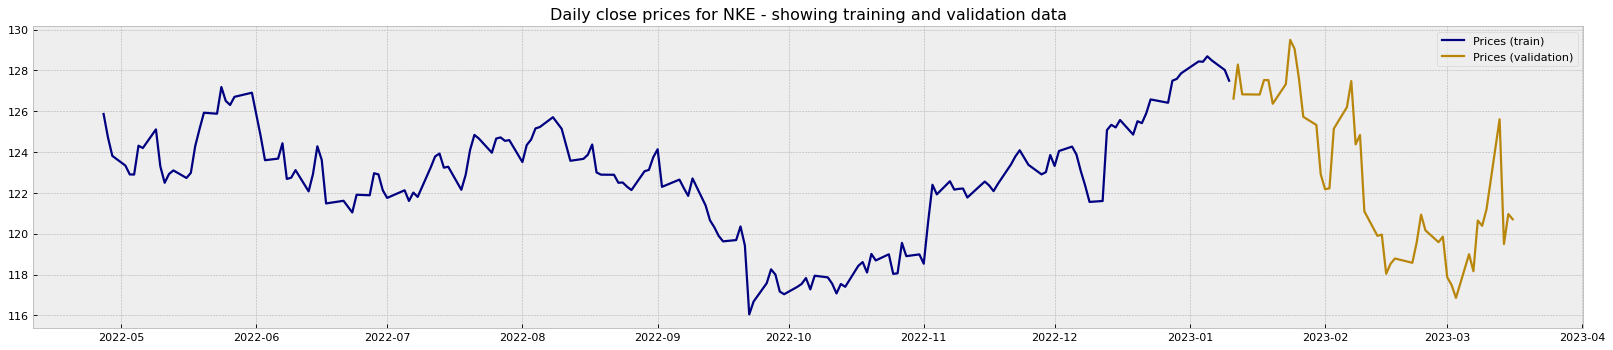

In [138]:
num_data_points, data_date, split_index, data_x_train_scaled, data_y_train_scaled, data_x_val_scaled, data_y_val_scaled = prepare_data(clean_data)

In [ ]:
data_date

## **OLD DATA PREPARING**

In [ ]:
#Prepare data
# scaler = MinMaxScaler(feature_range = (0,1))

# data_train_scaled = scaler.fit_transform(data_train.reshape(-1,1))
# data_test_scaled = scaler.transform(data_test.reshape(-1,1))

In [ ]:
# Separate data_train_scaled into train and validation sets 
# len_train = math.ceil(len(data_train_scaled)*0.8)

# X_train = []
# y_train = []

# for i in range(7, len_train):
#     X_train.append(data_train_scaled[(i-7):i,0])
#     y_train.append(data_train_scaled[i,0])

# # convert X_train, y_train to numpy arrays
# X_train, y_train = np.array(X_train), np.array(y_train)

# # Reshape the data
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# print(X_train.shape)

(153, 7, 1)


In [ ]:
# X_val = []
# y_val = []

# for i in range(len_train, len(data_train_scaled)):
#     X_val.append(data_train_scaled[(i-7):i,0])
#     y_val.append(data_train_scaled[i,0])
    
# X_val, y_val = np.array(X_val), np.array(y_val)

# X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
# print(X_val.shape)

(40, 7, 1)


In [ ]:
# df_train = df[:len_train]
# df_val = df[len_train:len(data_train_scaled)]

## **DEFINE MODEL AND TRAIN**

In [108]:
def sign_penalty(y_true, y_pred):
    penalty = 10
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)
    
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7f64b8b01af0>


In [152]:
#Build the LSTM Model
model = keras.Sequential()
#RNN:
model.add(LSTM(units = 50, return_sequences = True, input_shape = (data_x_train_scaled.shape[1], data_x_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Two dense layer
model.add(Dense(50,activation='tanh'))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# model.compile(optimizer = 'adam', loss = sign_penalty)
# Fitting the RNN to the Training set
model_callback = model.fit(data_x_train_scaled, data_y_train_scaled, epochs = 70, validation_split=0.1)
model.save('/content/driver/MyDrive/Colab Notebooks/LSTM_Edited_Binh')

Epoch 1/70
5/5 [==============================] - 8s 438ms/step - loss: 0.0392 - val_loss: 0.1466
Epoch 2/70
5/5 [==============================] - 0s 37ms/step - loss: 0.0371 - val_loss: 0.1224
Epoch 3/70
5/5 [==============================] - 0s 40ms/step - loss: 0.0344 - val_loss: 0.0972
Epoch 4/70
5/5 [==============================] - 0s 39ms/step - loss: 0.0331 - val_loss: 0.0715
Epoch 5/70
5/5 [==============================] - 0s 42ms/step - loss: 0.0325 - val_loss: 0.0681
Epoch 6/70
5/5 [==============================] - 0s 42ms/step - loss: 0.0319 - val_loss: 0.0736
Epoch 7/70
5/5 [==============================] - 0s 40ms/step - loss: 0.0325 - val_loss: 0.0938
Epoch 8/70
5/5 [==============================] - 0s 38ms/step - loss: 0.0319 - val_loss: 0.0804
Epoch 9/70
5/5 [==============================] - 0s 40ms/step - loss: 0.0310 - val_loss: 0.0706
Epoch 10/70
5/5 [==============================] - 0s 42ms/step - loss: 0.0316 - val_loss: 0.0657
Epoch 11/70
5/5 [===========

In [147]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 7, 50)             12000     
                                                                 
 dropout_8 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_9 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_10 (LSTM)              (None, 7, 50)             20200     
                                                                 
 dropout_10 (Dropout)        (None, 7, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

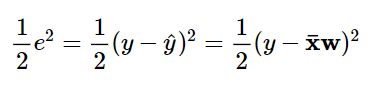

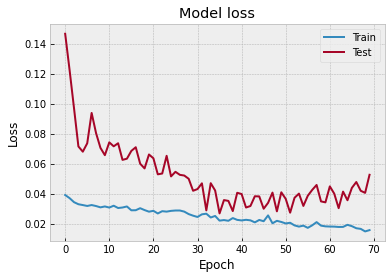

In [153]:
plot_loss(model_callback.history['loss'][0:], model_callback.history['val_loss'][0:])

## **TESTING**

In [131]:
# Train predict result 
predict_train  = model.predict(data_x_train_scaled)
# Test predict result 
predict_val = model.predict(data_x_val_scaled)
# Inverse transform into original 
predict_val = scaler.inverse_transform(predict_val)
# Actual value 
y_val_true = scaler.inverse_transform(data_y_val_scaled).reshape(-1, 1)

assert predict_val.shape == y_val_true.shape

2/2 [==============================] - 0s 11ms/step


In [132]:
error = np.sqrt(np.mean(predict_val - y_val_true)**2)
print(error)

2.1133811961613933


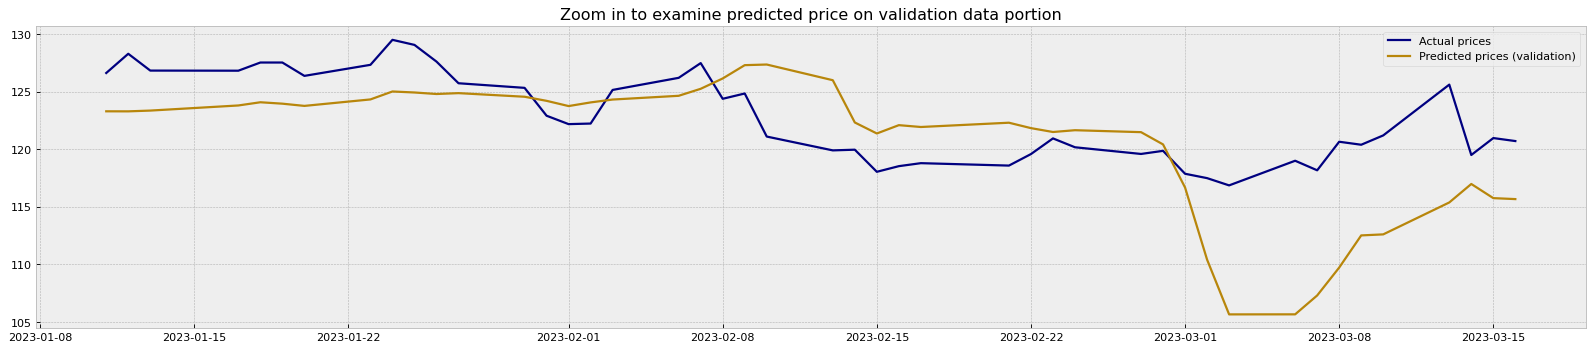

In [145]:
to_plot_date = data_date[split_index:]
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_date, y_val_true, label="Actual prices", color='navy')
plt.plot(to_plot_date, predict_val, label="Predicted prices (validation)", color='darkgoldenrod')
plt.title("Zoom in to examine predicted price on validation data portion")
plt.grid(visible = True, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## **BACKTESTING - PREDICTION**

In [ ]:
import datetime

Previous_Date = start.strftime ('%d-%m-%Y')
print ('Previous Date: ' + str(Previous_Date))

Current_Date = end.strftime ('%d-%m-%Y')
print ('Current Date: ' + str(Current_Date))
 
Next_Date_start = end + datetime.timedelta(days=1)
Next_Date_end = end + datetime.timedelta(days=7)

start_date_predict = Next_Date_start.strftime ('%d-%m-%Y')
end_date_predict = Next_Date_end.strftime ('%d-%m-%Y')

print(f'\nFocasting price trend next 7 days')
print ('Begin: ' + str(start_date_predict))
print ('Final: ' + str(end_date_predict))

Previous Date: 26-03-2022
Current Date: 26-03-2023

Focasting price trend next 7 days
Begin: 27-03-2023
Final: 02-04-2023


In [ ]:
#Load the test data
yf.pdr_override()

start_date = '26-03-2022'
end_date = '26-03-2023'

start = datetime.datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.datetime.strptime(end_date, '%d-%m-%Y')

test_data = pdr.get_data_yahoo(company, start=start, end=end)


actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'],test_data['Close']), axis = 0)
inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

#print(test_data)
#Visualize the test data
plt.figure(figsize=(20,8))
plt.title(company)
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(test_data['Close'], color='blue')
plt.show()

[*********************100%***********************]  1 of 1 completed


IndexError: ignored